<a href="https://colab.research.google.com/github/IITH-STP-ASSIGNMENTS/Basics-of-Linear-Algebra/blob/main/AIML_Module_2_Lab2_Principal_Components_Analysis_(PCA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data
## Lab 2: Principal Components Analysis (PCA)


---

This lab is designed to give you an understanding of Principal Components
Analysis (PCA). PCA has been called one of the most valuable results from applied linear algebra. PCA is used abundantly in all forms of analysis - from neuroscience to computer graphics - because it is a simple, non-parametric method of extracting relevant information from confusing data sets.

Principal Component Analysis (PCA) is a linear dimensionality reduction technique that can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.

PCA is generally used for 2 applications:
1.   Visualization of high dimentional datasets.
2.   Reducing number of features, thereby speeding up ML algorithms.


We will be primarily focussing on the first application in this lab.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes

In this lab, we will be using the breast_cancer dataset. The data has 569 samples with thirty features, and each sample has a label associated with it (benign or malignant).

In [55]:
from sklearn.datasets import load_diabetes

diabetes_data = load_diabetes().data
print("Features:", diabetes_data.shape)  ### 442 rows and 10 columns expected

diabetes_labels = np.reshape(load_diabetes().target, (442,1))
print("Target:",diabetes_labels.shape) ### 442 rows and 1 target column expected

Features: (442, 10)
Target: (442, 1)


In [56]:
## Creating a Pandas dataframe for the dataset with the last column as the target variable

final_diabetes_data = np.concatenate([diabetes_data, diabetes_labels],axis=1)
diabetes_dataset = pd.DataFrame(final_diabetes_data)

features = load_diabetes().feature_names
features_labels = np.append(features,'label')
diabetes_dataset.columns = features_labels
display(diabetes_dataset.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,label
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [64]:
# Dividing the values into the features and labels for convenience later on

X = diabetes_dataset.iloc[:,:10].values
y = diabetes_dataset.iloc[:,10].values

print(np.shape(X), np.shape(y))

(442, 10) (442,)


### Step By Step Computation Of PCA
The below steps need to be followed to perform dimensionality reduction using PCA:

1. Standardization of the data

2. Computing the covariance matrix

3. Calculating the eigenvectors and eigenvalues

4. Computing the Principal Components

5. Reducing the dimensions of the data set


### 1. Standardization of the data

---
It is a common practice to normalize your data before feeding it to any machine learning algorithm.

To apply normalization, you will import StandardScaler module from the sklearn library and then apply scaling by doing fit_transform on the feature data. While applying StandardScaler, each feature of your data should be normally distributed such that it will scale the distribution to a mean of zero and a standard deviation of one.


In [65]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

print(np.std(X_std))

0.9999999999999999


Here's the data after scaling. Yes, we do loose the numerical meaning of the data, but that's okay. We are more interested in the relative positions of the data points with respect to each other.

In [66]:
X_std_df = pd.DataFrame(X_std)
X_std_df.columns = features[:15]
X_std_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.800500,1.065488,1.297088,0.459841,-0.929746,-0.732065,-0.912451,-0.054499,0.418531,-0.370989
1,-0.039567,-0.938537,-1.082180,-0.553505,-0.177624,-0.402886,1.564414,-0.830301,-1.436589,-1.938479
2,1.793307,1.065488,0.934533,-0.119214,-0.958674,-0.718897,-0.680245,-0.054499,0.060156,-0.545154
3,-1.872441,-0.938537,-0.243771,-0.770650,0.256292,0.525397,-0.757647,0.721302,0.476983,-0.196823
4,0.113172,-0.938537,-0.764944,0.459841,0.082726,0.327890,0.171178,-0.054499,-0.672502,-0.980568


### 2. Computing the covariance matrix

---

Recall that covariance is always measured between 2 dimensions. If we have a data set with more than 2 dimensions, there is more than one covariance measurement that can be calculated. For example, from a 3 dimensional data set (dimensions x,y,z) you could calculate cov(x,y), cov(y,z) and cov(x,z). In fact, for an n-dimensional data set, you can calculate N combinatorial 2 different covariances.

Here we have 30 different features, so we will have to compute 435 different covariances.

In [69]:
mean_vec = np.mean(X_std, axis=0) ## Computing feature wise means

# Covariance matrix = i/(N-1) * X^T * X
# where X is the normalized feature matrix and N is the number of data points (rows)

cov_mat = 1/ (X_std.shape[0]-1) * (X_std - mean_vec).T.dot(X_std - mean_vec)

print("Covariance matrix first 5 rows and columns:")
print(cov_mat[0:5, 0:5])

Covariance matrix first 5 rows and columns:
[[1.00226757 0.17413106 0.18550436 0.33618819 0.26065053]
 [0.17413106 1.00226757 0.08836131 0.241557   0.03535681]
 [0.18550436 0.08836131 1.00226757 0.39630752 0.25034381]
 [0.33618819 0.241557   0.39630752 1.00226757 0.24301383]
 [0.26065053 0.03535681 0.25034381 0.24301383 1.00226757]]


In [70]:
cov_mat.shape

(10, 10)

A perhaps simpler way to do this is by using the numpy's covariance module "np.cov". However note that it takes as input the feature matrix with features in different rows, so in our application, we would be taking a transpose of the feature matrix before applying np.cov().

In [71]:
cov_mat_numpy = np.cov(X_std.T)

print("Covariance matrix first 5 rows and columns:")
print(cov_mat_numpy[0:5, 0:5])

Covariance matrix first 5 rows and columns:
[[1.00226757 0.17413106 0.18550436 0.33618819 0.26065053]
 [0.17413106 1.00226757 0.08836131 0.241557   0.03535681]
 [0.18550436 0.08836131 1.00226757 0.39630752 0.25034381]
 [0.33618819 0.241557   0.39630752 1.00226757 0.24301383]
 [0.26065053 0.03535681 0.25034381 0.24301383 1.00226757]]


### 3. Calculating the eigenvectors and eigenvalues

---

Since the covariance matrix is square, we can calculate the eigenvectors and eigenvalues for this matrix. These are rather important, as they tell us useful information about our data.

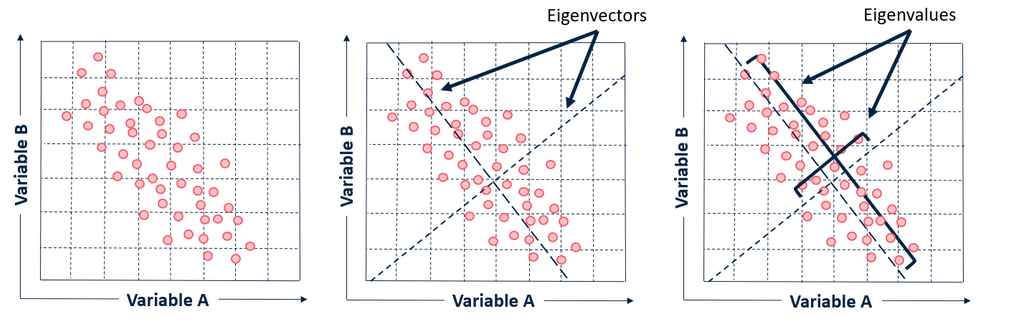

See how one of the eigenvectors goes through the middle of the points, like drawing a line of best fit? That eigenvector is showing us how these two data sets are related along that line. The second eigenvector gives us the other, less important, pattern in the data, that all the points follow the main line, but are off to the side of the main line by some amount.

So, by this process of taking the eigenvectors of the covariance matrix, we have
been able to extract lines that characterise the data.

In [72]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [73]:
eig_vals.shape, eig_vecs.shape

((10,), (10, 10))

### 4. Computing the Principal Components

---




Explained variance:
[np.float64(40.242107501527855), np.float64(14.923196775986957), np.float64(12.059662591250005), np.float64(9.554764032641128), np.float64(6.62181391266173), np.float64(6.027170756201254), np.float64(5.36565652319377), np.float64(4.336820363655842), np.float64(0.7832002446109024), np.float64(0.08560729827054206)]
Cumulative explained variance:
[ 40.2421075   55.16530428  67.22496687  76.7797309   83.40154481
  89.42871557  94.79437209  99.13119246  99.9143927  100.        ]


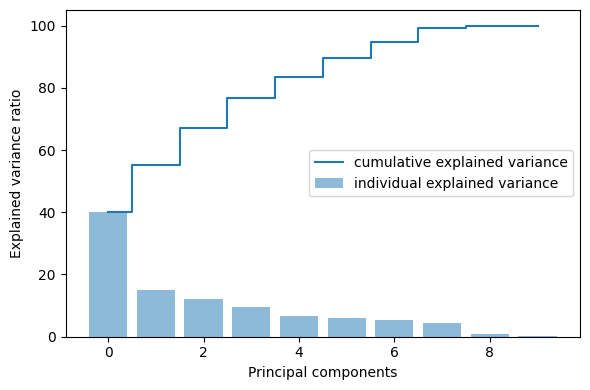

In [74]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
print("Explained variance:")
print(var_exp)

cum_var_exp = np.cumsum(var_exp)
print("Cumulative explained variance:")
print(cum_var_exp)

# Plotting the variance explained by each component and the cumulative variance explained

plt.figure(figsize=(6 , 4))
plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(len(var_exp)), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

So, the first principal component alone explains more than 40% variance in the dataset. Also note that considering all the 30 dimensions explains 100% of the variance in the dataset as expected.

Choosing a suitable number of components for further visualizations is generally based on the cumulative sum of PCs. The first 2 PCs explain nearly 65% variance, and the first 3 explain close to 75% variance.

Lets now try and reduce the dimensions of our dataset to the first 2 and 3 principal components

### 5. Reducing the dimensions of the data set

---



In [75]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(10,1),
                      eig_pairs[1][1].reshape(10,1),
                      eig_pairs[2][1].reshape(10,1)))

Y = X_std.dot(matrix_w)

print(Y)

[[-0.58719913  1.9468322  -0.58920548]
 [ 2.83162538 -1.37208173 -0.02792987]
 [-0.27212855  1.63490124 -0.73924374]
 ...
 [ 0.20520638  1.20548723 -0.4961862 ]
 [-0.69287112 -0.2101271   0.86872416]
 [ 1.90394067 -3.97577657  0.04833791]]


Now, that you have spent such a long time building this final matrix Y which has reduced each datapoint to 3 dimensions......

All of this can also be done in 2 lines by using sklearn's PCA module.

In [76]:
from sklearn.decomposition import PCA

sklearn_pca = PCA(n_components=3)
Y_sklearn = sklearn_pca.fit_transform(X_std)

print(Y_sklearn)

[[ 0.58719913 -1.9468322   0.58920548]
 [-2.83162538  1.37208173  0.02792987]
 [ 0.27212855 -1.63490124  0.73924374]
 ...
 [-0.20520638 -1.20548723  0.4961862 ]
 [ 0.69287112  0.2101271  -0.86872416]
 [-1.90394067  3.97577657 -0.04833791]]


## Let's visualize our dataset in 2 and 3 dimensions now

---



In [77]:
final_df = pd.DataFrame(columns=["PC1", "PC2", "PC3", "Label"])

for i in range(len(Y)):

    dicti = dict()

    dicti["PC1"] = Y[i, 0]
    dicti["PC2"] = Y[i, 1]
    dicti["PC3"] = Y[i, 2]
    if (int(breast_labels[i][0]) == 0):
      dicti["Label"] = "Benign"
    else:
      dicti["Label"] = "Malignant"

    final_df = pd.concat([final_df, pd.DataFrame([dicti])], ignore_index=True)


final_df.head()

/tmp/ipython-input-77-36910974.py:15: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,PC1,PC2,PC3,Label
0,-0.587199,1.946832,-0.589205,Benign
1,2.831625,-1.372082,-0.027930,Benign
2,-0.272129,1.634901,-0.739244,Benign
3,-0.049281,-0.382278,2.013032,Benign
4,0.756421,-0.811960,0.057238,Benign


In [78]:
import plotly.graph_objects as go
import plotly.express as px

In [79]:
for_x = final_df.PC1.tolist()
for_y = final_df.PC2.tolist()
for_label = final_df.Label.tolist()
for_hover = final_df.Label.tolist()

fig = px.scatter(x=for_x, y=for_y, color=for_label,
                 title="Principal Component Axis",
                 color_discrete_map={"Benign": "aqua", "Malignant": "yellow"})

fig.update_layout(
    xaxis=dict(title = 'PC1', showgrid=True, ticks='inside', zeroline=True, mirror=True, showline=True, linecolor='white'),
    yaxis=dict(title = 'PC2', showgrid=True, ticks='inside', zeroline=True, mirror=True, showline=True, linecolor='white'),
    plot_bgcolor='#555555',
    font=dict(
        family="Times New Roman",
        size=16,
        color="Black"))
fig.update_traces(marker=dict(size=8,))

fig.show(renderer = "colab")

### Question:
Referring to the plot above, can you reason why PCA can be a good candidate before training models for Machine learning?

#### Answer:
You can see that the first 2 principal components were able to differentiate the benign and malignant tumours in our breast cancer dataset. This motivates the use of the second application of PCA, which was to reduce the number of features in the dataset so that the machine learning algorithm can be trained without overfitting.



Let us now try and visualize this in the first 3 Principal Components space.

In [80]:
fig = px.scatter_3d(final_df, x='PC1', y='PC2', z='PC3', color='Label', title="Principal Component Axis")
fig.update_traces(marker=dict(size=6,))

fig.show(renderer = "colab")

Feel free to explore this interactive plot by PLOTLY, which is also another great tool for visualizations. You can zoom, pan, rotate, turn and download this plot.

Exersise
1. How many components do you need to retain 90% of the variance in the data?
2. Find one other use case that makes use of PCA and summarize how it is applied to the problem domain.

Looking back at the cumulative explained variance, let's find out how many components are needed to retain 90% of the variance in the data.

Another common use case for PCA is image compression.

Here's a summary of how it's applied:

**Represent Image as Data:** An image can be represented as a matrix of pixel values. For color images, this would be a 3D matrix (height, width, color channels).

**Apply PCA to Blocks or the Entire Image:** PCA can be applied to small blocks of the image or the entire image matrix. This identifies the principal components that capture the most significant variations in the pixel data.

**Retain Principal Components:** Instead of storing all the original pixel data, you only retain a smaller number of the most important principal components.

**Reconstruct Image:** The image is then reconstructed using only the retained principal components. Because the less important components (which often represent noise or fine details that are less noticeable) are discarded, the reconstructed image uses less data than the original.
This process results in a compressed image file. The level of compression depends on how many principal components are retained. Retaining fewer components leads to higher compression but potentially some loss of image quality.

### Some interesting references:

1. https://builtin.com/data-science/step-step-explanation-principal-component-analysis

2. http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf

3. https://www.cs.cmu.edu/~elaw/papers/pca.pdf

4. https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60